In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from datasets import load_dataset
import matplotlib.pyplot as plt
%matplotlib inline


torch.manual_seed(12046)

In [2]:
class LSTMCell(nn.Module):

    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        combined_size = self.input_size + self.hidden_size
        self.in_gate = nn.Linear(combined_size, self.hidden_size)
        self.forget_gate = nn.Linear(combined_size, self.hidden_size)
        self.new_cell_state = nn.Linear(combined_size, self.hidden_size)
        self.out_gate = nn.Linear(combined_size, self.hidden_size)

    def forward(self, inputs, state=None):
        B, _ = inputs.shape                                 # (B,     I)
        # state: ((B, H), (B, H))
        if state is None:
            state = self.init_state(B, inputs.device)
        hs, cs = state
        combined = torch.cat((inputs, hs), dim=1)           # (B, I + H)
        ingate = F.sigmoid(self.in_gate(combined))          # (B,     H)
        forgetgate = F.sigmoid(self.forget_gate(combined))  # (B,     H)
        outgate = F.sigmoid(self.out_gate(combined))        # (B,     H)
        # 更新细胞状态
        ncs = F.tanh(self.new_cell_state(combined))         # (B,     H)
        cs = (forgetgate * cs) + (ingate * ncs)             # (B,     H)
        # 更新隐藏状态
        hs = outgate * F.tanh(cs)                           # (B,     H)
        return hs, cs

    def init_state(self, B, device):
        cs = torch.zeros((B, self.hidden_size), device=device)
        hs = torch.zeros((B, self.hidden_size), device=device)
        return hs, cs

class LSTM(nn.Module):

    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.lstm = LSTMCell(self.input_size, self.hidden_size)

    def forward(self, inputs, state=None):
        re = []
        # B batch_size,
        # T sequence length,
        # C number of channels.
        B, T, C = inputs.shape
        inputs = inputs.transpose(0, 1)  # (T, B, C)
        for i in range(T):
            state = self.lstm(inputs[i], state)
            re.append(state[0])  # state[0]: (B, H)
        result_tensor = torch.stack(re, dim=0)  # (T, B, H)
        return result_tensor.transpose(0, 1)    # (B, T, H)

In [3]:
def test_lstm():
    B, T, input_size, hidden_size = torch.randint(1, 100, (4,))
    model = LSTM(input_size, hidden_size)
    ref_model = nn.LSTM(input_size, hidden_size, batch_first=True)
    # 取出模型参数
    p = list(ref_model.parameters())
    i, f, c, o = torch.cat((p[0], p[1]), dim=1).chunk(4, 0)
    ib, fb, cb, ob = (p[2] + p[3]).chunk(4, 0)
    # 设置模型参数
    model.lstm.in_gate.weight = nn.Parameter(i)
    model.lstm.in_gate.bias = nn.Parameter(ib)
    model.lstm.forget_gate.weight = nn.Parameter(f)
    model.lstm.forget_gate.bias = nn.Parameter(fb)
    model.lstm.new_cell_state.weight = nn.Parameter(c)
    model.lstm.new_cell_state.bias = nn.Parameter(cb)
    model.lstm.out_gate.weight = nn.Parameter(o)
    model.lstm.out_gate.bias = nn.Parameter(ob)
    # 随机生成输入
    inputs = torch.randn(B, T, input_size)
    state = torch.randn((2, B, hidden_size)).chunk(2, 0)
    _state = tuple((i.squeeze(0) for i in state))
    # 验证计算结果
    re = model(inputs, _state)
    ref_re, _ = ref_model(inputs, state)
    out = torch.all(re - ref_re < 1e-4)
    return out, (B, T, input_size, hidden_size)

test_lstm()

(tensor(True), (tensor(51), tensor(78), tensor(90), tensor(94)))

In [4]:
learning_rate = 1e-3
eval_iters = 10
batch_size=5000
sequence_len=64
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [5]:
raw_datasets = load_dataset("code_search_net", "python")
datasets = raw_datasets['train'].filter(lambda x: 'apache/spark' in x['repository_name'])

class char_tokenizer:

    def __init__(self, data):
        # 数据中出现的所有字符构成字典
        chars = sorted(list(set(''.join(data))))
        # 预留一个位置给结尾的特殊字符
        self.char2ind = {s : i + 1 for i, s in enumerate(chars)}
        self.char2ind['<|e|>'] = 0
        self.ind2char = {i : s for s, i in self.char2ind.items()}

    def encode(self, text):
        return [self.char2ind[c] for c in text]

    def decode(self, enc):
        if isinstance(enc, int):
            return self.ind2char[enc]
        return [self.ind2char[i] for i in enc]

tok = char_tokenizer(datasets['whole_func_string'])
len(tok.char2ind)

98

In [6]:
class CharLSTM(nn.Module):

    def __init__(self, vs):
        super().__init__()
        self.emb_size = 256
        self.hidden_size = 300
        self.embedding = nn.Embedding(vs, self.emb_size)
        self.dp = nn.Dropout(0.4)
        self.lstm1 = LSTM(self.emb_size, self.hidden_size)
        self.norm1 = nn.LayerNorm(self.hidden_size)
        self.lstm2 = LSTM(self.emb_size, self.hidden_size)
        self.norm2 = nn.LayerNorm(self.hidden_size)
        self.lstm3 = LSTM(self.emb_size, self.hidden_size)
        self.norm3 = nn.LayerNorm(self.hidden_size)
        self.h2o = nn.Linear(self.hidden_size, vs)

    def forward(self, x):
        # x: (B, T)
        emb = self.embedding(x)                   # (B, T,  C)
        h = self.norm1(self.dp(self.lstm1(emb)))  # (B, T,  H)
        h = self.norm2(self.dp(self.lstm2(emb)))  # (B, T,  H)
        h = self.norm3(self.dp(self.lstm3(emb)))  # (B, T,  H)
        output = self.h2o(h)                      # (B, T, vs)
        return output

model = CharLSTM(len(tok.char2ind)).to(device)

In [7]:
model

CharLSTM(
  (embedding): Embedding(98, 256)
  (dp): Dropout(p=0.4, inplace=False)
  (lstm1): LSTM(
    (lstm): LSTMCell(
      (in_gate): Linear(in_features=556, out_features=300, bias=True)
      (forget_gate): Linear(in_features=556, out_features=300, bias=True)
      (new_cell_state): Linear(in_features=556, out_features=300, bias=True)
      (out_gate): Linear(in_features=556, out_features=300, bias=True)
    )
  )
  (norm1): LayerNorm((300,), eps=1e-05, elementwise_affine=True)
  (lstm2): LSTM(
    (lstm): LSTMCell(
      (in_gate): Linear(in_features=556, out_features=300, bias=True)
      (forget_gate): Linear(in_features=556, out_features=300, bias=True)
      (new_cell_state): Linear(in_features=556, out_features=300, bias=True)
      (out_gate): Linear(in_features=556, out_features=300, bias=True)
    )
  )
  (norm2): LayerNorm((300,), eps=1e-05, elementwise_affine=True)
  (lstm3): LSTM(
    (lstm): LSTMCell(
      (in_gate): Linear(in_features=556, out_features=300, bias=Tru

In [8]:
@torch.no_grad()
def generate_batch(model, idx, max_new_tokens=300):
    for _ in range(max_new_tokens):
        # 限制背景长度，使之与模型训练时的状况更相符
        # 当然也可以不限制
        context = idx[:, -sequence_len:]
        logits = model(context)
        logits = logits[:, -1, :]
        probs = F.softmax(logits, dim=-1)
        ix = torch.multinomial(probs, num_samples=1)
        idx = torch.cat((idx, ix), dim=1)
        if ix.item() == 0:
            break
    return idx.tolist()[0]

In [9]:
begin_text = torch.tensor(tok.encode('def'), device=device).unsqueeze(0)
print(''.join(tok.decode(generate_batch(model, begin_text))))

def(f&Eu<$)KK:aQsW8qj5'\B5vDz@*T_PU_~x#HJc{$n!z~'<RN)VMn>,TFT%mdiö+dG4{O04?oJ95nd&#B+}=U'Lc[/ud)5m:0Q;oa'Od4G |eP *_~+iLJe]gK.a,|D0niIugu
Zm@STw=f%bp`CtPOk5-to05"E^wi<|e|>


In [10]:
def process(data, sequence_len=sequence_len):
    text = data['whole_func_string']
    inputs, labels = [], []
    for i in text:
        enc = tok.encode(i)
        enc += [0]
        for i in range(len(enc) - sequence_len):
            inputs.append(enc[i: i + sequence_len])
            labels.append(enc[i + 1: i + 1 + sequence_len])
    return {'inputs': inputs, 'labels': labels}

tokenized = datasets.map(process, batched=True, remove_columns=datasets.column_names)
tokenized.set_format(type='torch', device=device)
tokenized

Dataset({
    features: ['inputs', 'labels'],
    num_rows: 668546
})

In [11]:
from torch.utils.data import DataLoader

# 构建数据读取器
train_loader = DataLoader(tokenized, batch_size=batch_size, shuffle=True)
# 获取一个批量的数据
next(iter(train_loader))

{'inputs': tensor([[14,  2,  4,  ..., 71, 86, 14],
         [28,  1,  2,  ...,  2,  2,  2],
         [54, 84, 87,  ...,  2, 54, 84],
         ...,
         [81, 73, 43,  ...,  2, 53, 82],
         [82, 86, 71,  ..., 86, 81,  2],
         [84, 67, 79,  ...,  2, 69, 81]], device='cuda:0'),
 'labels': tensor([[ 2,  4, 67,  ..., 86, 14,  2],
         [ 1,  2,  2,  ...,  2,  2,  2],
         [84, 87, 71,  ..., 54, 84, 87],
         ...,
         [73, 43, 79,  ..., 53, 82, 67],
         [86, 71, 70,  ..., 81,  2, 67],
         [67, 79,  2,  ..., 69, 81, 84]], device='cuda:0')}

In [12]:
def estimate_loss(model):
    re = {}
    # 将模型切换至评估模式
    model.eval()
    re['train'] = _loss(model, train_loader)
    # 将模型切换至训练模式
    model.train()
    return re

@torch.no_grad()
def _loss(model, data_loader):
    """
    计算模型在不同数据集下面的评估指标
    """
    loss = []
    data_iter = iter(data_loader)
    for k in range(eval_iters):
        data = next(data_iter, None)
        if data is None:
            break
        inputs, labels = data['inputs'], data['labels']
        logits = model(inputs)
        logits = logits.transpose(-2, -1)
        loss.append(F.cross_entropy(logits, labels))
    return torch.tensor(loss).mean().item()

In [13]:
def train_lstm(model, optimizer, data_loader, epochs=10):
    lossi = []
    for epoch in range(epochs):
        for i, data in enumerate(data_loader, 0):
            inputs, labels = data['inputs'], data['labels']
            optimizer.zero_grad()
            logits = model(inputs)
            logits = logits.transpose(-2, -1)
            loss = F.cross_entropy(logits, labels)
            lossi.append(loss.item())
            loss.backward()
            optimizer.step()
        # 评估模型，并输出结果
        stats = estimate_loss(model)
        print(f'epoch {epoch:>2}: train loss {stats["train"]:.4f}')
    return lossi

In [14]:
l = train_lstm(model, optim.Adam(model.parameters(), lr=learning_rate), train_loader)

epoch  0: train loss 1.5573
epoch  1: train loss 1.2325
epoch  2: train loss 1.0660
epoch  3: train loss 0.9677
epoch  4: train loss 0.9050
epoch  5: train loss 0.8476
epoch  6: train loss 0.7968
epoch  7: train loss 0.7619
epoch  8: train loss 0.7283
epoch  9: train loss 0.6972


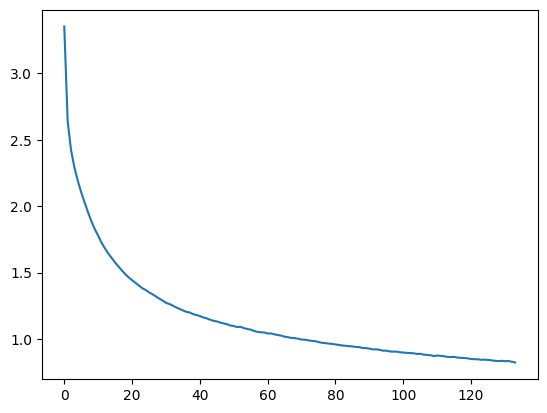

In [15]:
plt.plot(torch.tensor(l).view(-1, 10).mean(1).numpy())

In [16]:
begin_text = torch.tensor(tok.encode('def'), device=device).unsqueeze(0)
print(''.join(tok.decode(generate_batch(model, begin_text))))

default value, contributed reterialize

    True: Corretters intonegyores misified URING, may an operatorPoranrowise Keynand(doc, oldf = rdd[sered(x, mergeC=hcast(gd):
            jc) Bytes nore: this operation. For this by summary avoid func)
        batched = self.select(sort_ardas(esc, module)
     


In [17]:
# 将层归一化放到在LSTM神经元里面
class LSTMLayerNormCell(nn.Module):

    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        combined_size = self.input_size + self.hidden_size
        self.gates = nn.Linear(
            combined_size, 4 * self.hidden_size, bias=False)
        self.ln_gates = nn.LayerNorm(4 * self.hidden_size)
        self.ln_c = nn.LayerNorm(self.hidden_size)

    def forward(self, inputs, state=None):
        B, _ = inputs.shape  # (B, I)
        # state: ((B, H), (B, H))
        if state is None:
            state = self.init_state(B, inputs.device)
        hs, cs = state
        combined = torch.cat((inputs, hs), dim=1)  # (B, I + H)
        i, f, c, o = self.ln_gates(self.gates(combined)).chunk(4, 1)
        ingate = F.sigmoid(i)      # (B, H)
        forgetgate = F.sigmoid(f)  # (B, H)
        outgate = F.sigmoid(o)     # (B, H)
        # 更新细胞状态
        ncs = F.tanh(c)            # (B, H)
        cs = self.ln_c((forgetgate * cs) + (ingate * ncs))  # (B, H)
        # 更新隐藏状态
        hs = outgate * F.tanh(cs)                           # (B, H)
        return hs, cs

    def init_state(self, B, device):
        cs = torch.zeros((B, self.hidden_size), device=device)
        hs = torch.zeros((B, self.hidden_size), device=device)
        return hs, cs

class LSTMLayerNorm(nn.Module):

    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.lstm = LSTMLayerNormCell(self.input_size, self.hidden_size)

    def forward(self, inputs, state=None):
        re = []
        # B batch_size,
        # T sequence length,
        # C number of channels.
        B, T, C = inputs.shape
        inputs = inputs.transpose(0, 1)  # (T, B, C)
        for i in range(T):
            state = self.lstm(inputs[i], state)
            re.append(state[0])  # state[0]: (B, H)
        result_tensor = torch.stack(re, dim=0)  # (T, B, H)
        return result_tensor.transpose(0, 1)    # (B, T, H)

In [18]:
class CharLSTMLayerNorm(nn.Module):

    def __init__(self, vs):
        super().__init__()
        self.emb_size = 256
        self.hidden_size = 300
        self.embedding = nn.Embedding(vs, self.emb_size)
        self.dp = nn.Dropout(0.4)
        self.lstm1 = LSTMLayerNorm(self.emb_size, self.hidden_size)
        self.lstm2 = LSTMLayerNorm(self.emb_size, self.hidden_size)
        self.lstm3 = LSTMLayerNorm(self.emb_size, self.hidden_size)
        self.h2o = nn.Linear(self.hidden_size, vs)

    def forward(self, x):
        # x: (B, T)
        emb = self.embedding(x)       # (B, T,  C)
        h = self.dp(self.lstm1(emb))  # (B, T,  H)
        h = self.dp(self.lstm2(emb))  # (B, T,  H)
        h = self.dp(self.lstm3(emb))  # (B, T,  H)
        output = self.h2o(h)          # (B, T, vs)
        return output

model_norm = CharLSTMLayerNorm(len(tok.char2ind)).to(device)

In [19]:
l_norm = train_lstm(model_norm, optim.Adam(model_norm.parameters(), lr=learning_rate),
                    train_loader)

epoch  0: train loss 1.4733
epoch  1: train loss 1.1134
epoch  2: train loss 0.9508
epoch  3: train loss 0.8678
epoch  4: train loss 0.7982
epoch  5: train loss 0.7610
epoch  6: train loss 0.7228
epoch  7: train loss 0.7023
epoch  8: train loss 0.6776
epoch  9: train loss 0.6624


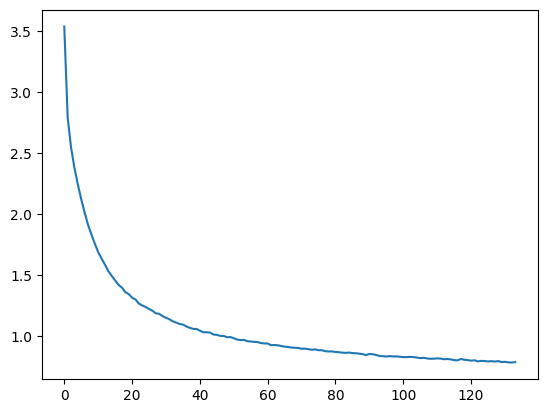

In [20]:
plt.plot(torch.tensor(l_norm).view(-1, 10).mean(1).numpy())

In [21]:
begin_text = torch.tensor(tok.encode('def'), device=device).unsqueeze(0)
print(''.join(tok.decode(generate_batch(model_norm, begin_text))))

def is_code()
        return QRoged, embers, element, of the a list of partitiode
        :param m:rrapiBy(e.gnowAtiveFulc(P# the contents of the quote characterto in eace new Dataset tacks skpoattof func, seed:
          Java columns to exc.
            if a:cun(False, "b"), scen),
                   
